In [92]:
# WHAT TO DO?
# FOLLOW THE NOTEBOOK:
# inspect the credit card dataset first (DONE)
# -> it is full of numerical variables formed from PCA
# follow the steps to get a good prediction (DONE)

# CLASSIFYING MEDICAL DATA!!!! READ UP ON THAT!
# A) STATQUEST
# B) MISC

# look for resources on classification with mixed data... the kaggle datasets had it ffs
# forests (TRIED ONCE)
# neural networks (TRY HERE)
# -> LOOK AT THE DEEP LEARNING SERIES ON KAGGLE, SPEEDRUN IT, SEE THE TYPES OF DATA AND TECHNIQUES USED
# -> GET AN INITIAL MEASURE OF HOW IT WORKS

# nearest neighbours (gower or whatever) (may not work, but try it nonetheless)
# clustering
# svm
# xgboost
# decision trees

# can a linear model accept categorical variables?
# try stuff out with a linear model, then exhaust it
# by exhaustion, i mean hyperparameter tuning
# regularization, types of imputing
# that will be the next report
# send the report by tomorrow.

# ONLY THEN will you proceed to other models.

In [197]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import itertools
from xgboost import XGBClassifier
import time

In [196]:
tic = time.time()
!pip install xgboost
toc = time.time()
print(f"time = {toc - tic}")

  Using cached xgboost-2.0.3-py3-none-win_amd64.whl (99.8 MB)
time = 6.665719270706177


In [30]:
# CURRENT GOAL: IMPLEMENT A NEURAL NETWORK.
data = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_cleaned_data.csv")
data

,AGE,SEX,DM,HTN,CKD,INCIDENTAL,PAIN,HEMATURIA,MASS,LOW,...,T,N,M,IVC INV,MAX DIA,APPROACH,HISTOPATHOLOGY,GRADE,MONTHS,RECURRENCE
0,32,M,0,0,0,0,1,0,0,0.0,...,2,0,1,0,8.0,2,clear cell,2.0,95,0
1,45,F,0,0,0,0,1,1,0,0.0,...,4,1,1,0,4.9,1,clear cell,2.0,95,0
2,47,M,0,0,0,1,0,0,0,0.0,...,3b,0,1,1,9.0,1,clear cell,3.0,95,0
3,58,M,0,0,0,0,0,1,0,0.0,...,3a,0,0,0,7.0,2,clear cell,2.0,95,1
4,22,M,0,0,0,0,1,0,0,0.0,...,2b,0,0,0,10.4,1,clear cell,2.0,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,64,M,0,0,0,0,1,0,0,0.0,...,3a,0,0,0,8.0,1,clear cell,4.0,18,0
691,49,M,0,0,0,0,0,1,0,0.0,...,2a,0,0,0,10.0,1,clear cell,3.0,18,0
692,73,M,0,1,0,0,0,1,0,0.0,...,3b,0,0,1,7.5,2,clear cell,1.0,18,0
693,65,F,0,0,0,0,1,0,0,0.0,...,3a,0,0,0,10.0,1,clear cell,1.0,18,0


In [17]:
data.LOW.value_counts()

0.0    648
1.0     46
Name: LOW, dtype: int64

In [18]:
data.RECURRENCE.value_counts()

0    608
1     87
Name: RECURRENCE, dtype: int64

In [31]:
data.loc[64, 'LOW'] = 0
data.loc[0, 'T'] = '2a'
x = data.copy()
y = x.pop("RECURRENCE")

In [7]:
# ALT: 0TH INDEX -> 2B, 64: LOW = 0
# REST: ORDINAL ENCODING AND THE REST.

In [20]:
for col in x.columns:
    if (x[col].dtype == object):
        print(col, x[col].dtype)

SEX object
SITE object
T object
HISTOPATHOLOGY object


In [21]:
ordinal_mapping = {'1a':0, '1b':1, '2a':2, '2b':3, '3a':4, '3b':5, '3c':6, '4':7}
x['ORDINAL_T'] = x['T'].replace(ordinal_mapping).astype(int)
x.drop('T', axis = 1, inplace = True)
column = x.pop('ORDINAL_T')
x.insert(12, column.name, column)

In [22]:
x

,AGE,SEX,DM,HTN,CKD,INCIDENTAL,PAIN,HEMATURIA,MASS,LOW,...,SITE,ORDINAL_T,N,M,IVC INV,MAX DIA,APPROACH,HISTOPATHOLOGY,GRADE,MONTHS
0,32,M,0,0,0,0,1,0,0,0.0,...,left,2,0,1,0,8.0,2,clear cell,2.0,95
1,45,F,0,0,0,0,1,1,0,0.0,...,right,7,1,1,0,4.9,1,clear cell,2.0,95
2,47,M,0,0,0,1,0,0,0,0.0,...,right,5,0,1,1,9.0,1,clear cell,3.0,95
3,58,M,0,0,0,0,0,1,0,0.0,...,right,4,0,0,0,7.0,2,clear cell,2.0,95
4,22,M,0,0,0,0,1,0,0,0.0,...,left,3,0,0,0,10.4,1,clear cell,2.0,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,64,M,0,0,0,0,1,0,0,0.0,...,right,4,0,0,0,8.0,1,clear cell,4.0,18
691,49,M,0,0,0,0,0,1,0,0.0,...,right,2,0,0,0,10.0,1,clear cell,3.0,18
692,73,M,0,1,0,0,0,1,0,0.0,...,right,5,0,0,1,7.5,2,clear cell,1.0,18
693,65,F,0,0,0,0,1,0,0,0.0,...,left,4,0,0,0,10.0,1,clear cell,1.0,18


In [23]:
x['ORDINAL_T']

0      2
1      7
2      5
3      4
4      3
      ..
690    4
691    2
692    5
693    4
694    4
Name: ORDINAL_T, Length: 695, dtype: int32

In [26]:
x = pd.get_dummies(x, columns = ['SEX', 'HISTOPATHOLOGY', 'SITE'])

In [38]:
num_cols = []
for col in x.columns:
    if x[col].dtype != object:
        num_cols.append(col)
num_cols

['AGE',
 'DM',
 'HTN',
 'CKD',
 'INCIDENTAL',
 'PAIN',
 'HEMATURIA',
 'MASS',
 'LOW',
 'FEVER',
 'N',
 'M',
 'IVC INV',
 'MAX DIA',
 'APPROACH',
 'GRADE',
 'MONTHS']

In [148]:
class ManualOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping, column):
        self.mapping = mapping
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()  # Create a copy to avoid modifying the original DataFrame
        X_copy[self.column] = X_copy[self.column].map(self.mapping)
        return X_copy

# Define your mapping for ordinal encoding
cancer_stage_mapping = {'1a':0, '1b':1, '2a':2, '2b':3, '3a':4, '3b':5, '3c':6, '4':7}

# Assuming 'grade' is the name of the column containing NaN values
# grade_imputer = SimpleImputer(strategy='most_frequent')

# preprocessor = make_column_transformer(
#     (grade_imputer, ['GRADE']),
#     (StandardScaler(), num_cols),
# #     (OneHotEncoder(sparse=False), ['SEX', 'HISTOPATHOLOGY', 'SITE']),
# #     (ManualOrdinalEncoder(mapping=cancer_stage_mapping, column = 'T'), ['T']),
# )

# # Apply the column transformer to your data
# X_transformed = preprocessor.fit_transform(x)
# print(X_transformed.shape)

# Define the imputer and scaler separately
grade_imputer = SimpleImputer(strategy='most_frequent', fill_value = 0)

# Define the column transformer with a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler, num_cols),
        ('onehot', OneHotEncoder(sparse=False), ['SEX', 'HISTOPATHOLOGY', 'SITE']),
        ('ordinal', ManualOrdinalEncoder(mapping=cancer_stage_mapping, column='T'), ['T']),
#         ('grade_imputer', grade_imputer, ['GRADE']),
    ],
)

# Create a pipeline with the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('grade_imputer', grade_imputer)
])

pre_X_non_test, pre_X_test, y_non_test, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)

# APPLY K-FOLD CV LATER
pre_X_train, pre_X_valid, y_train, y_valid = train_test_split(pre_X_non_test, y_non_test, test_size = 0.25, shuffle = True)

# Fit and transform the data
X_train = pipeline.fit_transform(pre_X_train)
X_valid = pipeline.transform(pre_X_valid)
X_test = pipeline.transform(pre_X_test)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(417, 25)
(139, 25)
(139, 25)


In [149]:
np.isnan(X_train).sum()

0

In [150]:
print(X_train[0])

[ 0.48293552 -0.38158144 -0.54316761 -0.17938288  1.48583051 -0.81731267
 -0.53946425 -0.13066434 -0.2578685  -0.20615528 -0.27842302 -0.35212103
 -0.2416105  -0.79600795  0.42761483 -1.13309276 -0.27919852  1.
  0.          1.          0.          0.          1.          0.
  0.        ]


In [151]:
X_train.shape[1]

25

In [163]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_transformed.shape[1]]),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation = 'sigmoid'),
    layers.Dense(1, activation = 'sigmoid', input_shape=[X_transformed.shape[1]]),
])
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_transformed, y,
    validation_data=(X_valid, y_valid),
    batch_size=20,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1, # hide the output because we have so many epochs
)

Epoch 1/100
35/35 [==============================] - 3s 13ms/step - loss: 0.5852 - binary_accuracy: 0.8748 - val_loss: 0.5639 - val_binary_accuracy: 0.8777
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 0.5561 - binary_accuracy: 0.8748 - val_loss: 0.5453 - val_binary_accuracy: 0.8777
Epoch 3/100
35/35 [==============================] - 0s 6ms/step - loss: 0.5388 - binary_accuracy: 0.8748 - val_loss: 0.5290 - val_binary_accuracy: 0.8777
Epoch 4/100
35/35 [==============================] - 0s 6ms/step - loss: 0.5233 - binary_accuracy: 0.8748 - val_loss: 0.5139 - val_binary_accuracy: 0.8777
Epoch 5/100
35/35 [==============================] - 0s 6ms/step - loss: 0.5090 - binary_accuracy: 0.8748 - val_loss: 0.5002 - val_binary_accuracy: 0.8777
Epoch 6/100
35/35 [==============================] - 0s 6ms/step - loss: 0.4960 - binary_accuracy: 0.8748 - val_loss: 0.4878 - val_binary_accuracy: 0.8777
Epoch 7/100
35/35 [==============================] - 0s 6ms/step - lo

35/35 [==============================] - 0s 5ms/step - loss: 0.3775 - binary_accuracy: 0.8748 - val_loss: 0.3720 - val_binary_accuracy: 0.8777
Epoch 54/100
35/35 [==============================] - 0s 6ms/step - loss: 0.3774 - binary_accuracy: 0.8748 - val_loss: 0.3720 - val_binary_accuracy: 0.8777
Epoch 55/100
35/35 [==============================] - 0s 6ms/step - loss: 0.3774 - binary_accuracy: 0.8748 - val_loss: 0.3720 - val_binary_accuracy: 0.8777
Epoch 56/100
35/35 [==============================] - 0s 6ms/step - loss: 0.3773 - binary_accuracy: 0.8748 - val_loss: 0.3719 - val_binary_accuracy: 0.8777


Best Validation Loss: 0.3719
Best Validation Accuracy: 0.8777


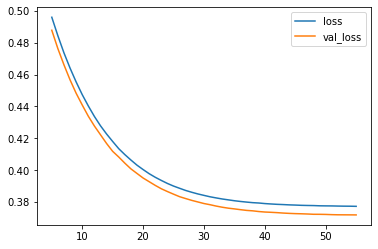

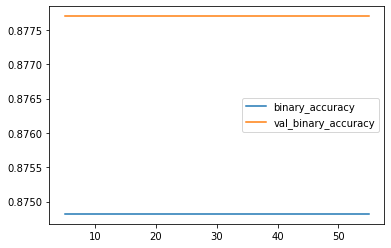

In [164]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [174]:
y_pred_test = (model.predict(X_test) > 0.5).astype(int).reshape((-1,))
y_pred_test.shape, y_test.shape

5/5 [==============================] - 0s 5ms/step


((139,), (139,))

In [ ]:
# look at the undersampling thing first

In [78]:
np.isnan(X_transformed).sum(axis = 0)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [183]:
# Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)

# Calculate metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(conf_matrix)
# True positive, true negative, false positive, false negative
tp, tn, fp, fn = conf_matrix.ravel()

# Sensitivity (Recall for positive class)
sensitivity = tp / (tp + fn)

# Specificity (Recall for negative class)
specificity = tn / (tn + fp)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print(f"tp: {tp}")
print(f"tn: {tn}")
print(f"fp: {fp}")
print(f"fn: {fn}")
print("\nPrecision:", precision)
print("Recall (Sensitivity):", recall)
print("F1 Score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

[[123   0]
 [ 16   0]]
Confusion Matrix:
[[123   0]
 [ 16   0]]
tp: 123
tn: 0
fp: 16
fn: 0

Precision: 0.8848920863309353
Recall (Sensitivity): 1.0
F1 Score: 0.9389312977099237
Sensitivity: 1.0
Specificity: 0.0


In [182]:
from sklearn import metrics

# Assuming y_true and y_pred are your true labels and predicted labels, respectively
y_true = np.array([1, 0, 1, 1, 0, 1, 0, 1])
y_pred = np.array([1, 0, 1, 0, 0, 1, 1, 1])

# Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)

# Calculate metrics
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)

# True positive, true negative, false positive, false negative
tp, tn, fp, fn = conf_matrix.ravel()

# Sensitivity (Recall for positive class)
sensitivity = tp / (tp + fn)

# Specificity (Recall for negative class)
specificity = tn / (tn + fp)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nPrecision:", precision)
print("Recall (Sensitivity):", recall)
print("F1 Score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Confusion Matrix:
[[123   0]
 [ 16   0]]

Precision: 0.0
Recall (Sensitivity): 0.0
F1 Score: 0.0
Sensitivity: 1.0
Specificity: 0.0


C:\Users\aniru\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [187]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [188]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.1875


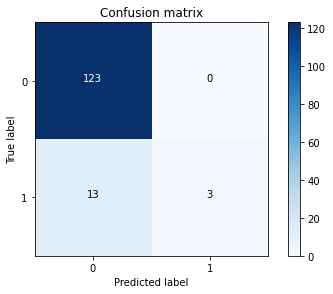

In [192]:
y_test_pred = lr.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [198]:
my_model = XGBClassifier()
my_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Recall metric in the testing dataset:  0.25


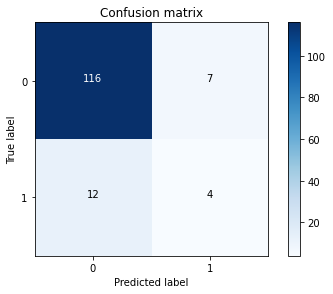

In [200]:
predictions = my_model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()